# Backpacker accomodation price estimator

In this section, a user-friendly calculator has been developed to provide price estimates for backpacking trips. This tool takes key inputs such as location, hostel ratings, distance to the city center, and the duration of stays at each hostel. In response, it offers an estimated minimum cost for the entire backpacking adventure.

The primary objective of this tool is to provide backpackers with a reliable means of estimating their expenses, enabling them to make informed decisions as they plan their journeys.

## Dorm price prediction model

The first step involved creating a powerful predictive model for dormitory prices. This model serves as the engine driving the price estimation tool. A clean dataset was used, excluding specific columns like "name," "description," and "minimum private room price" since these details are often unknown when estimating prices for hypothetical hostels. To ensure accuracy, rows with missing data related to dormitory prices were also removed.

The model development started with the importation of essential libraries and modules to facilitate data preprocessing and modeling tasks. Subsequently, a series of data preprocessing operations ensue, encompassing the imputation of missing values, feature scaling, creation of dummy variables for categorical attributes, and the partitioning of the dataset into training and test subsets. Afterwards, the Mean Absolute Error (MAE) for a baseline model and three different regression models (linear regression, Lasso regression, and Ridge regression) was calculated and returned this results:

- The "Baseline model" yields an MAE of 4.7648, serving as a reference point for comparison.
- The "Linear Regression" model demonstrates an exceedingly high MAE of 2.0179e+13, suggesting significant inaccuracies in its predictions. This is probably due to multicolinearity coming from the fact that generating dummies from the city values resulted in a data set with a high amount of columns.
- The "Lasso Regression" model produces an MAE of 4.8140, which is comparable to the baseline model's error.
- The "Ridge Regression" model records an MAE of 3.8497, implying relatively improved predictive performance compared to the other models.

The MAE values serve as a critical metric for assessing the predictive accuracy of each model, with lower MAE values indicating better performance. In the light of the aforementioned results, the Ridge model seem the best option for the regression model development and it was further finetuned. 

In [62]:
# Import the pandas library to work with data frames
import pandas as pd

# Load the cleaned data from a CSV file into a data frame
df = pd.read_csv("backpacking_hostel_data_cleaned.csv")

# Remove the specified columns ("name", "description", "min_private_price") from the data frame
df = df.drop(columns=["name", "description", "min_private_price"], axis=1)

# Remove rows with missing values in the "min_dorm_price" column
df = df.dropna(subset=["min_dorm_price"])

# Reset the index of the data frame to eliminate gaps in the index
df.reset_index(drop=True, inplace=True)

# Print the count of missing values for each column
print(df.isna().sum())

# Display the first few rows of the cleaned data frame
display(df.head())

country             0
city                0
rating            126
reviews             0
km_to_centre       44
min_dorm_price      0
dtype: int64


,country,city,rating,reviews,km_to_centre,min_dorm_price
0,Colombia,Medellin,9.6,160,14.65,14.63
1,Colombia,Medellin,10.0,6,1.85,11.25
2,Colombia,Medellin,9.6,28,2.44,10.35
3,Colombia,Medellin,9.5,5,2.43,7.88
4,Colombia,Medellin,9.4,901,4.79,18.00


In [63]:
# Import necessary modules
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, Normalizer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn import linear_model

# Instantiate a SimpleImputer to fill missing values with median for numerical columns
imp_median = SimpleImputer(strategy='median')

# Define the list of numerical columns in the dataset
numerical_columns = ["rating", "reviews", "km_to_centre"]

# Instantiate a MinMaxScaler for feature scaling
scaler = MinMaxScaler()

# Create dummy variables for categorical features, dropping the first category to avoid multicollinearity
df_dummies = pd.get_dummies(df, drop_first=True)

# Separate feature variables (X) and the target variable (y)
X = df_dummies.drop("min_dorm_price", axis=1)
y = df_dummies["min_dorm_price"]

# Impute missing values with median and use scale the specified numerical features
X[["rating", "km_to_centre"]] = imp_median.fit_transform(X[["rating", "km_to_centre"]])
X.loc[:, numerical_columns] = scaler.fit_transform(X.loc[:, numerical_columns])

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Determine the majority class (median) in the training data
median_mdp = y_train.median()

# Predict the majority class for all instances in the test set
y_pred = [median_mdp] * len(y_test)

# Calculate and print the Mean Absolute Error (MAE) for the baseline model
mae_bm = mean_absolute_error(y_test, y_pred)
print(f"MAE of Baseline model: {mae_bm:.4f}")

# Initialize linear regression, Lasso, and Ridge regression models with specified alpha
lm = linear_model.LinearRegression()
Lasso = linear_model.Lasso()
Ridge = linear_model.Ridge()

# Create a list of models to iterate through
model_list = [lm, Lasso, Ridge]

# Initialize an empty list to store outlier indices
outlier_index = []

# Loop through the list of models
for model in model_list:
    # Fit each model to the training data
    model.fit(X_train, y_train)
    
    # Make predictions using the model
    y_pred = model.predict(X_test)
    
    # Calculate the Mean Absolute Error (MAE) for each model
    mae = mean_absolute_error(y_test, y_pred)
    
    # Print the MAE for each model
    print(f"MAE of {model}: {mae:.4f}")

MAE of Baseline model: 4.7648
MAE of LinearRegression(): 20178663846241.4180
MAE of Lasso(): 4.8140
MAE of Ridge(): 3.8497


The Ridge regression model was trained with different alpha values, and the Mean Absolute Error (MAE) is calculated for each alpha. The resulting MAE values are plotted against the alpha values to visualize the impact of alpha on model performance, helping to choose an appropriate regularization strength. The plot shows that the lowest MAE and thus best results are obtained when using an alpha value of 1.3.

The importance of features was visualized then by plotting the magnitude of their coefficients and the factors with the most significant impact on the model were identified. Additionally, the effect of removing features of the model based on an importance coefficient threshold was evaluated in order to simplify and potential improve the model. Nevertheless, since the observed improvements coming from removing features with low importance coefficients were very small, it was decided to keep all features within the model. 

The final Ridge regression model attains a Mean Absolute Error of 3.8470, signifying an enhancement of 19.26% when compared with the baseline model. When comparing predicted and actual values in the test set, it was observed that more than 50% predicted the actual price with a margin of error of +-25%. 

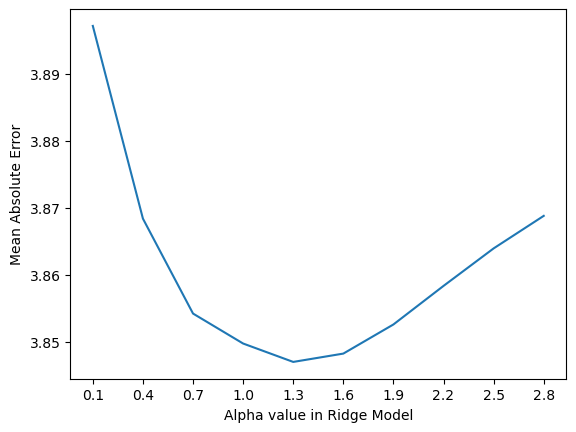

In [64]:
# Define a range of values for the 'alpha' hyperparameter in the Ridge model
alphas = np.arange(0.1, 3, 0.3)

# Initialize a list to store Mean Absolute Error (MAE) values for each alpha
mae_list = []

# Iterate through each alpha value
for alpha in alphas:
    # Create a Ridge model with the current 'alpha'
    ridge = linear_model.Ridge(alpha=alpha)

    # Fit the Ridge model to the training data
    ridge.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred_ridge = ridge.predict(X_test)

    # Calculate the MAE and add it to the list
    mae = mean_absolute_error(y_test, y_pred_ridge)
    mae_list.append(mae)

# Plot the relationship between 'alpha' values and MAE scores
sns.lineplot(x=alphas, y=mae_list)
plt.xticks(alphas)
plt.xlabel("Alpha value in Ridge Model")
plt.ylabel("Mean Absolute Error")
plt.show()


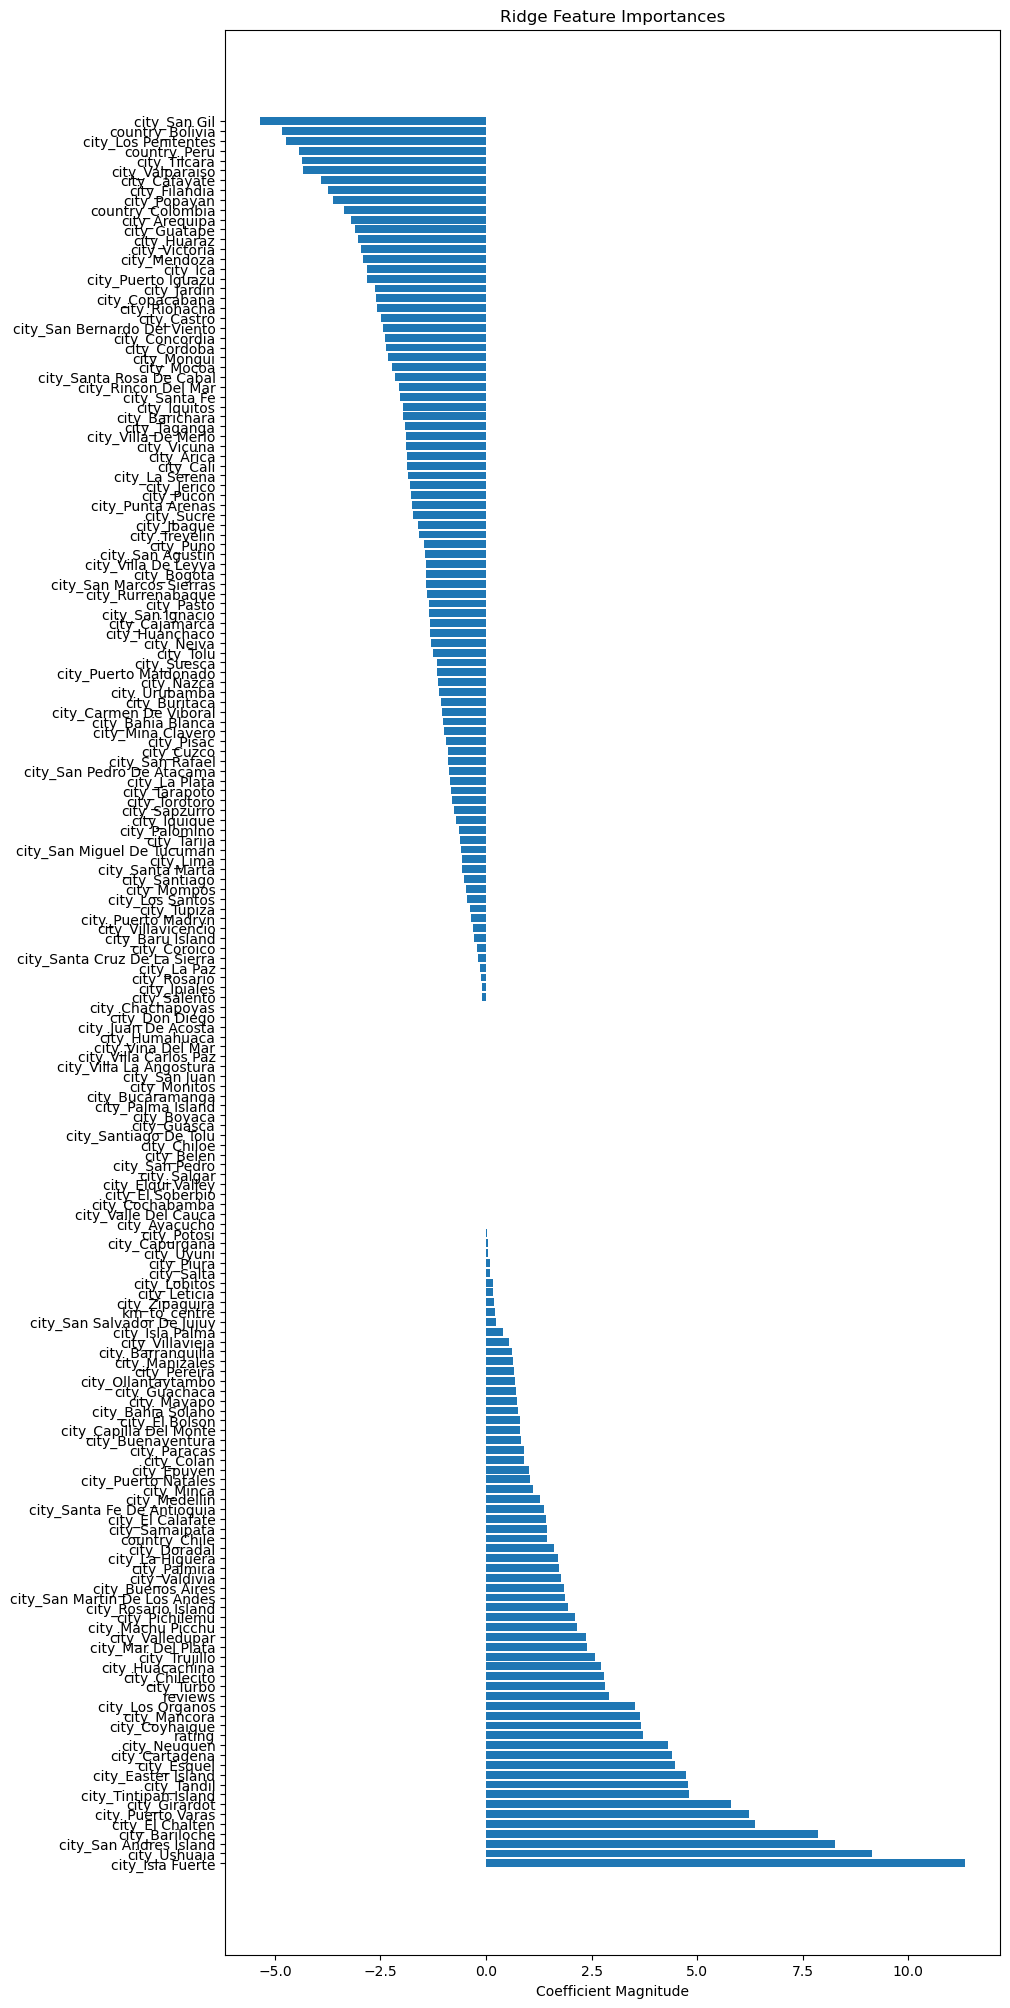

,Feature,Coefficient
66,city_Isla Fuerte,11.344361
162,city_Ushuaia,9.149872
127,city_San Andres Island,8.276633
13,city_Bariloche,7.871747
47,city_El Chalten,6.366288
114,city_Puerto Varas,6.233791
53,city_Girardot,5.810721
154,city_Tintipan Island,4.805729
150,city_Tandil,4.792583
44,city_Easter Island,4.729746


,Feature,Coefficient
5,country_Colombia,-3.360700
107,city_Popayan,-3.623318
52,city_Filandia,-3.748641
23,city_Cafayate,-3.919432
167,city_Valparaiso,-4.341425
153,city_Tilcara,-4.356558
6,country_Peru,-4.435855
79,city_Los Penitentes,-4.734510
3,country_Bolivia,-4.838045
129,city_San Gil,-5.343304


In [65]:
# Fit the Ridge model
ridge = linear_model.Ridge(alpha=1.3)  # You can adjust the alpha (regularization strength) if needed
ridge.fit(X_train, y_train)

# Get the absolute values of the Ridge coefficients
ridge_coefs = ridge.coef_

# Create a DataFrame to associate feature names with their coefficients
ridge_coefs_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': ridge_coefs})

# Sort the DataFrame by coefficient magnitude in descending order
ridge_coefs_df = ridge_coefs_df.sort_values(by='Coefficient', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 25))
plt.barh(ridge_coefs_df['Feature'], ridge_coefs_df['Coefficient'])
plt.xlabel('Coefficient Magnitude')
plt.title('Ridge Feature Importances')
plt.show()

# Print the factors with the biggest impact on the model
increase_price = ridge_coefs_df.head(10) 
decrease_price = ridge_coefs_df.tail(10) 
display(increase_price)
display(decrease_price)


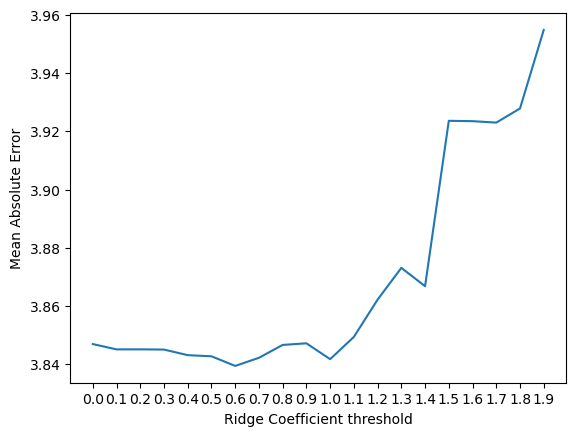

In [66]:
# Set threshold values to test
thresholds = np.arange(0, 2, 0.1)

# Instantiate list to save MAE values for different coefficient thresholds
mae_list = []

for i in thresholds:
    # Identify the columns to keep based on the threshold
    columns_to_keep = X.columns[np.abs(ridge_coefs) >= i]

    # Filter the X_train and X_test datasets to keep only the selected columns
    X_train_filtered = X_train[columns_to_keep]
    X_test_filtered = X_test[columns_to_keep]

    # Fit a Ridge model using the filtered features
    ridge_filtered = linear_model.Ridge(alpha=1.3)
    ridge_filtered.fit(X_train_filtered, y_train)

    # Make predictions and calculate MAE using the filtered features
    y_pred_filtered = ridge_filtered.predict(X_test_filtered)
    mae_filtered = mean_absolute_error(y_test, y_pred_filtered)
    mae_list.append(mae_filtered)

# Plot the relationship between 'n_neighbors' and accuracy scores
sns.lineplot(x=thresholds, y=mae_list)
plt.xticks(thresholds)
plt.xlabel("Ridge Coefficient threshold")
plt.ylabel("Mean Absolute Error")
plt.show()

In [67]:
# Fit a Ridge model using the filtered features
ridge = linear_model.Ridge(alpha=1.3)
ridge.fit(X_train, y_train)

# Make predictions and calculate MAE using the filtered features
y_pred = ridge.predict(X_test)
mae_final = mean_absolute_error(y_test, y_pred)

print(f"The Mean Absolute Error of our predictive model is {mae_final:.4f}")

model_improvement = (mae_bm - mae_final) / mae_bm * 100

print(f"The Ridge regression model shows an improvement in the MAE of {model_improvement:.2f}% compared to the baseline model")

The Mean Absolute Error of our predictive model is 3.8470
The Ridge regression model shows an improvement in the MAE of 19.26% compared to the baseline model


In [87]:
# Create a DataFrame to compare actual and predicted values
new_dict = {"actual": y_test, "predicted": y_pred}
result_df = pd.DataFrame(new_dict)

# Define the error percentage
error = 25

# Calculate error value as a percentage of actual values
result_df["error_value"] = result_df["actual"] / 100 * error

# Calculate lower and upper limits based on the error
result_df["lower_limit"] = result_df["actual"] - result_df["error_value"]
result_df["upper_limit"] = result_df["actual"] + result_df["error_value"]

in_range = []

# Check if predicted values fall within the defined range
for i, row in result_df.iterrows():
    if row['lower_limit'] <= row['predicted'] <= row['upper_limit']:
        in_range.append(True)
    else:
        in_range.append(False)

# Create a new column indicating whether predictions are in range
result_df["in_range"]  = in_range

# Display the count of predictions in and out of range and the entire DataFrame
display(result_df["in_range"].value_counts(normalize=True))


True     0.54698
False    0.45302
Name: in_range, dtype: float64

## Accomodation price estimator

The provided code defines a function accomodation_price_estimator that estimates accommodation expenses for a trip based on input data such as countries, cities, ratings, reviews, distances to city centers, and the number of days in each location. The function adds the input data as new rows to an existing DataFrame, preprocesses the data, uses a Ridge regression model to predict minimum dorm prices, calculates total trip expenses, and displays the relevant results.

In [90]:
# Define a function to estimate accommodation expenses for a trip
def accomodation_price_estimator(countries, cities, ratings, reviews, km_to_centres, days=[1]):
    # Create a new row with input data
    new_row = {
            'country': countries,
            'city': cities,
            'rating': ratings,
            'reviews': reviews,
            'km_to_centre': km_to_centres,
            'min_dorm_price': 0
        }

    # Create a DataFrame with the new rows and concatenate it with the original DataFrame
    df_row = pd.DataFrame(new_row)
    df2 = pd.concat([df, df_row], ignore_index=True)
    
    # Create dummy variables for categorical features, drop the first category to avoid multicollinearity
    df_dummies = pd.get_dummies(df2, drop_first=True)

    # Separate feature variables (X) and the target variable (y)
    X_new = df_dummies.drop("min_dorm_price", axis=1)
    y_new = df_dummies["min_dorm_price"]
    
    # Set the "days" value for the new rows
    new_rows_df = df2.iloc[-len(countries):, :]
    new_rows_df["days"] = days

    # Impute missing values with median and scale the specified numerical features
    X_new[["rating", "km_to_centre"]] = imp_median.fit_transform(X_new[["rating", "km_to_centre"]])
    X_new.loc[:, numerical_columns] = scaler.fit_transform(X_new.loc[:, numerical_columns])    
    
    # Fit a Ridge regression model
    ridge = linear_model.Ridge(alpha=1.3)
    ridge.fit(X_train, y_train)
    
    # Predict minimum dorm prices for the new rows
    y_pred = ridge.predict(X_new.tail(len(countries)))
       
    # Update the DataFrame with the predicted values and calculate total trip expenses
    new_rows_df["min_dorm_price"] = y_pred
    new_rows_df["total"] = round(new_rows_df["min_dorm_price"], 2) * new_rows_df["days"]
    total_trip = new_rows_df["total"].sum()
    
    # Display relevant columns of the DataFrame and the total trip cost
    display(new_rows_df.iloc[:, [0, 1, 2, 3, 4, 6, 5, 7]])
    print(f"The estimated minimal amount spent on dorms for the trip is {total_trip}€")

# Example usage of the function
accomodation_price_estimator(["Colombia"], ["Medellin"], [9.5], [20], [0.5], [3])

# Example usage of the function with several destinationa
accomodation_price_estimator(["Colombia", "Argentina", "Chile"], 
                             ["Medellin", "Salta", "Valparaiso"], 
                             [9.5, 9, 8], 
                             [20, 20, 5], 
                             [0.5, 3, 0.8], 
                             [3, 5, 7])


C:\Users\lucas\AppData\Local\Temp\ipykernel_10640\3746359635.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_rows_df["days"] = days
C:\Users\lucas\AppData\Local\Temp\ipykernel_10640\3746359635.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_rows_df["min_dorm_price"] = y_pred
C:\Users\lucas\AppData\Local\Temp\ipykernel_10640\3746359635.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

,country,city,rating,reviews,km_to_centre,days,min_dorm_price,total
991,Colombia,Medellin,9.5,20,0.5,3,12.892601,38.67


The estimated minimal amount spent on dorms for the trip is 38.67€


C:\Users\lucas\AppData\Local\Temp\ipykernel_10640\3746359635.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_rows_df["days"] = days
C:\Users\lucas\AppData\Local\Temp\ipykernel_10640\3746359635.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_rows_df["min_dorm_price"] = y_pred
C:\Users\lucas\AppData\Local\Temp\ipykernel_10640\3746359635.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

,country,city,rating,reviews,km_to_centre,days,min_dorm_price,total
991,Colombia,Medellin,9.5,20,0.5,3,12.892601,38.67
992,Argentina,Salta,9.0,20,3.0,5,14.866215,74.35
993,Chile,Valparaiso,8.0,5,0.8,7,11.394314,79.73


The estimated minimal amount spent on dorms for the trip is 192.75€
